Programación para la ciencia de datos
============================

--- 

Caso de ejemplo: Análisis de la estructura a gran escala del Universo
-----------------------------------------------------

---


In [7]:
import pandas as pd
import os
from scipy.integrate import quad
base_folder = os.getenv('PROJECT_TFM')
print(base_folder+'\\data\\2dfgrs-valid.csv')
data = pd.read_csv(base_folder+'\\data\\2dfgrs\\2dfgrs-valid.csv')
data

C:\desarrollo\git\uoc\tfm\data\2dfgrs-valid.csv


,GAL_ID,ra,dec,x,y,z,redshift,dist,GROUP_ID
0,2,3.627292,-32.966861,0.099988,0.006339,-0.064981,0.1229,0.119417,12097
1,3,3.586292,-32.388000,0.085393,0.005352,-0.054273,0.1038,0.101322,542
2,5,3.608000,-32.711528,0.084924,0.005355,-0.054652,0.1036,0.101132,4846
3,6,3.612542,-32.862444,0.106340,0.006714,-0.068832,0.1308,0.126850,4847
4,7,3.613417,-33.013278,0.089646,0.005661,-0.058362,0.1099,0.107120,1462
...,...,...,...,...,...,...,...,...,...
104907,332683,218.192917,-2.104833,-0.043573,-0.034280,-0.002038,0.0562,0.055478,12096
104908,332688,218.184250,-2.088833,-0.043808,-0.034454,-0.002033,0.0565,0.055770,12096
104909,332689,218.172000,-2.404389,-0.091945,-0.072281,-0.004911,0.1204,0.117058,78706
104910,332691,218.189667,-2.685111,-0.031195,-0.024539,-0.001861,0.0401,0.039733,78707


The element diferential density in polar coordnates is $$dV= \rho ^2 d\rho\, sin\theta d\theta\, d\varphi$$

In [10]:
import math


H0 = 70 # Hubble constanst
def parse_distance_megaparsecs(d):
    '''
    Parse raw distances to h-1Mpc
    #977.8 coefficent for converting 1/H into Gyr (Hubble time)
    (H0/100) * d * 977.8 * 1000 /(3.262*H0)  
    '''
    return d * 977.8 * 10 /(3.262) 

In [12]:
min_redsifth = 0.0
max_redsifth = 0.15
ra_min = 0.0
ra_sup = 30
dec_min = -36.0
dec_sup = -25.0
dec_min = -30.0
dec_sup = -27.0

data_sample = data[(data['ra'] <= ra_sup) & (data['ra'] >= ra_min) 
                & (data['dec'] >= dec_min) & (data['dec'] <= dec_sup)
                & (data['redshift'] >= min_redsifth) 
                & (data['redshift'] <= max_redsifth)]
#calculate the actual bounds
min_redsifth = data_sample['redshift'].min()
max_redsifth = data_sample['redshift'].max()
ra_min = data_sample['ra'].min()
ra_sup = data_sample['ra'].max()
dec_min = data_sample['dec'].min()
dec_sup = data_sample['dec'].max()
#Convert distances to h-1 MP
data = data_sample
data['dist_mp'] = data['dist'].apply(parse_distance_megaparsecs)
data['x'] = data['x'].apply(parse_distance_megaparsecs)
data['y'] = data['y'].apply(parse_distance_megaparsecs)
data['z'] = data['z'].apply(parse_distance_megaparsecs)
max_dist = max(data_sample['dist_mp'])
min_dist = 0

data_sample.shape

(5067, 10)

First of all we transform distances to $h^-1Mpc$

In [13]:
data

,GAL_ID,ra,dec,x,y,z,redshift,dist,GROUP_ID,dist_mp
15829,63517,3.492083,-27.383139,384.675769,23.474428,-199.624039,0.1500,0.144793,1062,434.023332
15830,63518,3.500875,-27.775806,371.713808,22.740688,-196.147943,0.1453,0.140417,22356,420.906533
15831,63519,3.488333,-27.570861,240.119424,14.637257,-125.608677,0.0925,0.090535,22357,271.383726
15832,63523,3.499333,-28.259111,317.439344,19.411715,-170.950106,0.1240,0.120454,22358,361.065770
15833,63525,3.476083,-27.981528,220.974652,13.422806,-117.619335,0.0853,0.083631,2857,250.687607
...,...,...,...,...,...,...,...,...,...,...
52746,155361,26.188542,-27.214556,343.017313,168.700244,-196.576346,0.1485,0.143397,45569,429.840563
52753,155382,26.000917,-27.058167,281.986615,137.539646,-160.260587,0.1209,0.117530,45574,352.302513
52778,155431,25.704667,-27.116333,309.466336,148.967134,-175.877834,0.1328,0.128728,45596,385.867377
52789,155454,25.550375,-27.104417,221.410216,105.846310,-125.606365,0.0940,0.091971,45606,275.686205


Generate a mock catalog:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Foereach dV we get the same number of galaxies.
# dV = (ro^2)dr sin(dec) d(ra)  --> para angúlos pequeños sin(dec) ~ dec

def ro_t(x):
    """ returns the result of x^2 """
    return x**2

# definimos función para generar el catálogo simulado
def to_radians(angle):
    return angle * math.pi / 180

def simulateCatalog(limits, n_gal, plotRho = False):
    """A simulated catalogue of n_gal galaxies is returned in the given limits
    
       Args:
         limits: (:obj:`dict`): with keys "Dist_min", "Dist_max", "dec_min","dec_max","ra_min","ra_max"
         n_gal:  (:obj:`int`)
         
       Optional Args:
         plotRho: (:obj:`boolean`): Returns plot to see distribution of rho. 
                  
       Retruns:
         pos_cat: (:obj:`numpy array` with shape n_gal x 3): position in cartesian coordinates of the n_gal galaxies
    
    """
    if not isinstance(limits, dict):
        print('Input must by a dictionary')
        return False
    else:
        if "dist_min" not in limits or "dist_max" not in limits:
             raise AssertionError('distMin and distMax keys must be given')
        if "dec_min" not in limits or  "dec_max" not in limits:
             raise AssertionError('dec_min and dec_max keys must be given')
        if "ra_min" not in limits or "ra_max" not in limits:
             raise AssertionError('ra_min and ra_max keys must be given')
            
        dist_min = limits["dist_min"] 
        dist_max =  limits["dist_max"]
        # Generem nombres aleatoris uniformes, amb els límits imposats 
        # i el mateix número de galàxies que el catàleg real
        
        ro3 = np.random.uniform(low=ro_t(dist_min),
                        high=ro_t(dist_max), size=n_gal)  
        dec = np.random.uniform(low=limits["dec_min"],
                        high=limits["dec_max"], size=n_gal)
        ra = np.random.uniform(low=limits["ra_min"],
                        high=limits["ra_max"], size=n_gal)

        # We come back to equatorial coordinates
        ro = (ro3)**(0.5)
        
        
        if plotRho:
            _ = plt.hist(ro)  # ( _ = added to avoid unnecesary text with plot info )
            plt.xlabel(r'$\rho$')
            plt.ylabel('Number of galaxies')

        # Again, cartesian coords and group in vectors
        x_cat = ro * np.cos(to_radians(dec)) * np.cos(to_radians(ra))
        y_cat = ro * np.cos(to_radians(dec)) * np.sin(to_radians(ra))
        z_cat = ro * np.sin(to_radians(dec))
        pos_cat = np.column_stack((x_cat, y_cat, z_cat))
        
        return pos_cat 
        
limits = {'ra_min': ra_min, 'ra_max': ra_sup,
          "dec_min": dec_min, "dec_max": dec_sup,
          "dist_min": min_dist, "dist_max": max_dist}

p_cat = simulateCatalog(limits, len(data), plotRho = False)
print("RA  limits: {}, {}".format(ra_min, ra_sup))
print("DEC limits: {}, {}".format(dec_min, dec_sup))
print("DIS limits: {}, {}".format(min_dist, max_dist))        
       

RA  limits: 0.0015416666666666, 29.994666666666667
DEC limits: -29.996194444444445, -27.000055555555555
DIS limits: 0, 434.02333212262386


In [17]:
xx = list()
yx = list()
zx = list()
for p in p_cat:
    xx.append(p[0])
    yx.append(p[1])
    zx.append(p[2])


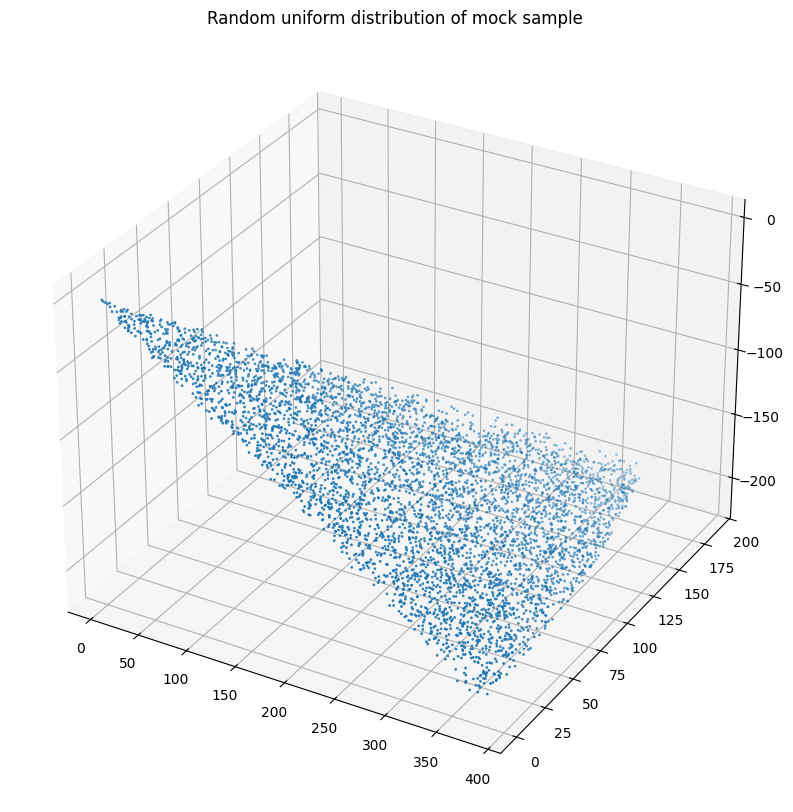

In [20]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(xx, yx, zx, s=2, linewidth=0.5)
plt.title("Random uniform distribution of mock sample")
plt.show()

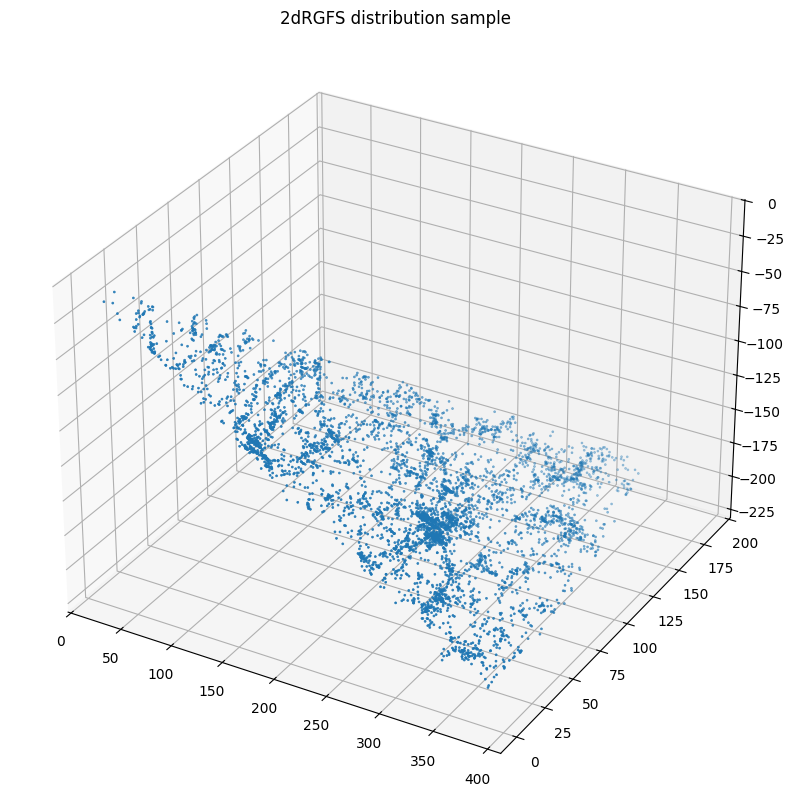

In [21]:
   
X = data[[ 'x', 'y', 'z']]
x = X['x']
y = X['y']
z = X['z']
colors = data[['GROUP_ID']]
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
plt.title("2dRGFS distribution sample")
ax.scatter(x, y, z, s=2, linewidth=0.5)
plt.show()

Generate a matrix with coordinates of actual points

In [23]:
%%time
# Tenemos que calcular el número de galaxias que hay a cierta distancia, tanto del catálogo real como del
# catálogo aleatorio. Utilizaremos Counter del módulo collections


from collections import Counter


# Definimos la distancia entre 2 puntos 
def euclidean(p1, p2):
    """ compute euclidian distance between two points p1 and p2"""
    if len(p1) != len(p2):
        raise AssertionError("x1 and x2 must be equal")
    suma = sum([(p1[i]-p2[i])**2 for i in range(len(p1))])
    return np.sqrt(suma)


dr = 1
# Generamos vectores con las coordenadas 
p = np.column_stack((np.array(data["x"]),
                     np.array(data["y"]), np.array(data["z"])))

# Bins gneration
bins = np.arange(min_dist, max_dist, dr)  # generamos intérvalos de distancia

digitized = None
digitized_cat = None
distances_lan = None
distances = None

for i in range(len(p)):
    distances =     np.array([euclidean(p[i], p[j])         for j in range(i+1, len(p))])
    distances_cat = np.array([euclidean(p_cat[i], p_cat[j]) for j in range(i+1, len(p))])
    distances_lan = np.array([euclidean(p[i], p_cat[j]) for j in range(len(p))])
    #print(distances[i])
    digitized = np.digitize(distances, bins)          # colocamos cada distancia a su intérvalo
    digitized_cat = np.digitize(distances_cat, bins)  
    digitized_lan = np.digitize(distances_lan, bins)

    if i == 0:
        DDc = Counter(digitized)       # utilizamos Counter para contar cuantas distancias hay iguales
        RRc = Counter(digitized_cat)
        DRc = Counter(digitized_lan)
    else:
        DDc.update(digitized)          # actualizamos contadores
        RRc.update(digitized_cat)
        DRc.update(digitized_lan)

# Ordenamos DDc i RRc
DDsorted = {k: v for k, v in sorted(DDc.items())}
RRsorted = {k: v for k, v in sorted(RRc.items())}
DRsorted = {k: v for k, v in sorted(DRc.items())}

# Lo pasamos a listas
r = list(DDsorted.keys())     # distancia
DD = list(DDsorted.values())  # número de pares del catálogo real
RR = list(RRsorted.values())  # número de pares del catálogo simulado
DR = list(DRsorted.values())  # número de pares del catálogo simulado

CPU times: total: 4min 51s
Wall time: 4min 54s


In [24]:
print("Mock catalog DDsorted {}".format(len(DDsorted.values())))
print("BINs {}".format(len(bins)))
print("r {}".format(len(r)))
print("Mock DD {}".format(len(DD)))
print("Actual catalog RR {}".format(len(RR)))
print("DR {}".format(len(DR)))
print("DD, RR and r must have same dimension")

Mock catalog DDsorted 407
BINs 435
r 407
Mock DD 407
Actual catalog RR 430
DR 430
DD, RR and r must have same dimension


Equalize lengths:

In [25]:
if len(RR) <  len(DD):
    for i in list(range(len(DD)- len(RR))):
        DD.pop()
        r.pop()
if len(DD) <  len(RR):
    for i in list(range(len(RR)- len(DD))):
        RR.pop()
        
if len(DD) <  len(DR):
    for i in list(range(len(DR)- len(DD))):
        DR.pop()

CPU times: total: 15.6 ms
Wall time: 16.8 ms


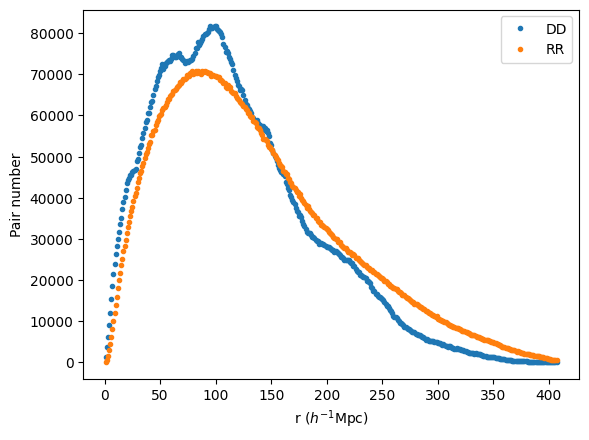

In [26]:
%%time
# Podemos ver que DD y RR son diferentes:
plt.plot(r, DD, '.', label='DD')
plt.plot(r, RR, '.', label='RR')
#plt.plot(r, DR, '.', label='DR')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel('Pair number')
plt.legend()

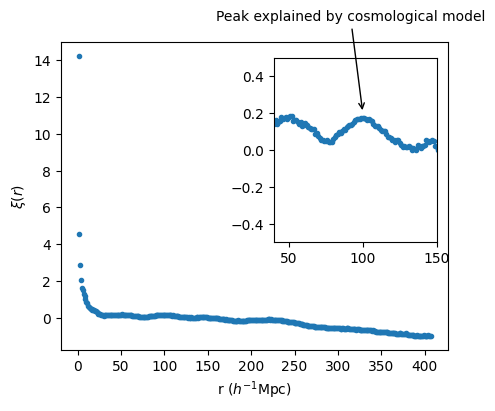

In [27]:
# Calculamos estimador natural
corr = np.array(DD)/np.array(RR) - 1 # Davids and Peebels
#corr = (np.array(DD)-np.array(DR))/np.array(RR) # Hamilton
#corr = (np.array(DD)-2*np.array(DR)+np.array(RR))/np.array(RR) # Landy and Szalay
#corr = np.array(DD)/np.array(DR)-1 # Hewett

# Hacemos los gráficos
fig, ax = plt.subplots(figsize=[5, 4])
# Fem el gràfic
ax.plot(r, corr, '.')
ax.set_xlabel("r ($h^{-1}$Mpc)")
ax.set_ylabel(r"$\xi(r)$")

axins = ax.inset_axes([0.55, 0.35, 0.42, 0.60])
axins.plot(r, corr, '.')
# sub region of the original image
x1, x2, y1, y2 = 40, 150, -0.5, 0.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
_ = axins.annotate("Peak explained by cosmological model",
                   xy=(100, 0.2), xycoords='data',
                   xytext=(0.6, 0.7), textcoords='data',
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3")
                   )

These peaks close to the 100 $h^{-1}$Mpc (1$h^{-1}$Mpc = 0.7Mpc ) are explained by the cosmological model.
Globally speaking, the probability to find galaxies diminsh with the distance, this is expected, but around 100 $h^{-1}$Mpc density grows again until a certain point, producing the peaks of density.

Such peaks have to do with the fluctuations produced in the early universe, the explanation is as follows: in the early universe, both baryonic and dark matter were bended and bounded and starting expanding with the universe.


Both kind of matter "feel" the gravity tug, in opposite way of expanding Universe and try to compress the matter, this generate therefore a first peak of density.

But in early epoch of Universe radiation was the dominant force, contibuting to expanding universe. Radiation different form gravity is only felt by barionic matter but not for the dark matter (which by definition do not react to radiation force). This difference produced the second density peak and is thougth that its high is in fact a measure of the dark and baryonic matter realtion. 

In [ ]:
# Calculamos estimador natural
#corr = np.array(DD)/np.array(RR) - 1 #Davids and Peebels
#corr = (np.array(DD)-np.array(DR))/np.array(RR) # Hamilton
#corr = (np.array(DD)-2*np.array(DR)+np.array(RR))/np.array(RR) # Landy and Szalay
corr = (np.array(DD)/np.array(DR)) - 2*(np.array(DR)/np.array(RR))+1 # Landy and Szalay

# Hacemos los gráficos
fig, ax = plt.subplots(figsize=[5, 4])
# Fem el gràfic
ax.plot(r, corr, '.')
ax.set_xlabel("r ($h^{-1}$Mpc)")
ax.set_ylabel(r"$\xi(r)$")

axins = ax.inset_axes([0.55, 0.35, 0.42, 0.60])
axins.plot(r, corr, '.')
# sub region of the original image
x1, x2, y1, y2 = 40, 120, 1.8, 4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
_ = axins.annotate("Peaks explained by cosmological model",
                   xy=(140, 0.09), xycoords='data',
                   xytext=(0.4, 0.4), textcoords='data',
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3")
                  )